In [1]:
import json
from models import Darknet
from train import hyp
from utils import torch_utils
from utils.utils import compute_loss, build_targets
from fastai.vision import *

In [2]:
# Download and untar data
# https://github.com/cedrickchee/knowledge/blob/master/courses/fast.ai/deep-learning-part-2/2018-edition/lesson-8-object-detection.md
voc2007 = untar_data(URLs.PASCAL_2007)
voc2012 = untar_data(URLs.PASCAL_2012)

In [3]:
# Load images and annotations
# https://pjreddie.com/darknet/yolo/#train-voc
files = [
    voc2007 / 'train.json',
    voc2007 / 'valid.json',
    voc2007 / 'test.json',
    voc2012 / 'train.json',
    voc2012 / 'valid.json'
    ]
jsons = [(it, json.load(it.open())) for it in files]
images = [{**img, 'file': fn} for (fn, json) in jsons for img in json["images"]]
images = { i["id"] : i for i in images }
annotations = [item for (fn, json) in jsons for item in json["annotations"]]
f"{len(images)}; {len(annotations)}"

'21503; 62199'

In [4]:
# Normalize data, slap annotations onto images to which they belong
for anno in annotations:
    image = images[anno['image_id']]
    image.setdefault('annotations', []).append(anno)


In [5]:
# Find the 1 category we care about
person_cat = [it for it in jsons[0][1]["categories"] if it["name"] == "person"][0]["id"]
person_cat

15

In [6]:
# Build lists of positive and negative samples
def has_person(img):
    return [] != [a for a in img['annotations'] if a['category_id'] == person_cat]
positive_samp = [img for img in images.values() if has_person(img)]
negative_samp = [img for img in images.values() if not has_person(img)]
f"{len(positive_samp)}; {len(negative_samp)}"

'8566; 12937'

In [7]:
# Truncate negative samples to be roughly same length as positive
negative_samp = negative_samp[:len(positive_samp)]
len(negative_samp)

8566

In [8]:
# Combine sample sets back together
samples = positive_samp #+ negative_samp

In [9]:
# Build the paths and pass them to the FastAI ObjectItemList
def get_folder(f):
    if 'train' in str(f) or 'valid' in str(f): return 'train'
    return 'test'
def make_path(p):
    return p['file'].parent / get_folder(p['file']) / p['file_name']
posix_paths = [make_path(p) for p in samples]
# lst = ImageList(posix_paths)
lst = ObjectItemList(posix_paths)

In [10]:
# Build a HashSet of validation files so we can quickly split later
def split_func(sample):
    return '2007' in str(sample['file'].parent) and 'test' in str(sample['file'])
valid = set()
for sample in samples:
    if split_func(sample):
        valid.add(make_path(sample))
len(valid)

2097

In [11]:
# Create function for FastAI to get labels
# https://github.com/cedrickchee/knowledge/blob/master/courses/fast.ai/deep-learning-part-2/2018-edition/lesson-8-object-detection.md#convert-vocs-bounding-box
def hw_bb(bb):
    return np.array([ bb[1], bb[0], bb[3] + bb[1] - 1, bb[2] + bb[0] - 1 ])
def filename_to_key(filename):
    trunk = os.path.splitext(filename)[0]
    txt = trunk.replace("_", "")
    id = int(txt)
    return id
def get_y_func(path):
    key = filename_to_key(path.name)
    image = images[key]
    boxes = [hw_bb(a['bbox']) for a in image['annotations'] if a['category_id'] == person_cat]
    classes = ['person'] * len(boxes)
    return [boxes, classes]

In [12]:
# Turn all this into a FastAI DataBunch so we can train
data = (lst
        .split_by_valid_func(lambda it: it in valid)
        .label_from_func(get_y_func)
        .transform(
            get_transforms(),
            tfm_y=True,
            size=(352, 608),
            resize_method=ResizeMethod.PAD,
            padding_mode = 'border'
        )
        .databunch(bs=16, collate_fn=bb_pad_collate))

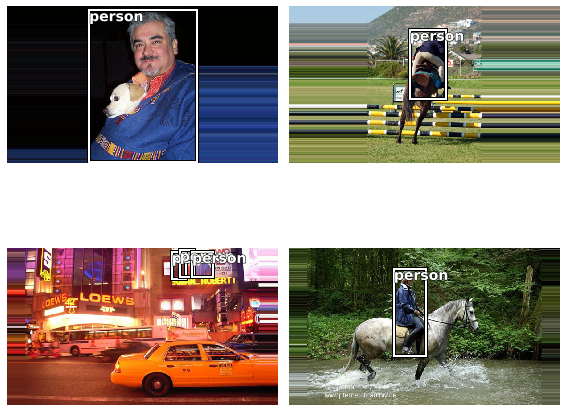

In [13]:
# Show the images so we can visually validate
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(8,8))


In [14]:
# Load the model
device = 'cpu' # 'cuda:0'
arc = 'default'
cfg = 'cfg/yolov3-tiny-anchors.cfg'
device = torch_utils.select_device(device, apex=False, batch_size=64)
model = Darknet(cfg, arc=arc).to(device)
model.arc = 'default'
model.nc = 1  # num classes
model.hyp = hyp
device

Using CPU



device(type='cpu')

In [15]:
# Define a custom loss function that translate between FastAI and Ultralytics
def loss_func(predicted, boxes, classes):
    targets = []
    bs = classes.shape[0]
    max_detections = classes.shape[1]
    for img_idx in range(bs):
        for detect_idx in range(max_detections):
            clazz = classes[img_idx, detect_idx]
            if clazz == 0: continue
            x, y, w, h = boxes[img_idx, detect_idx]
            targets.append([img_idx, float(clazz-1), float(x), float(y), float(w), float(h)])
    ft = torch.cuda.FloatTensor if predicted[0].is_cuda else torch.Tensor
    targets = ft(targets)
    loss, _ = compute_loss(predicted, targets, model)
    return loss[0]

In [16]:
# Finally we have everything we need to make a learner
learner = Learner(data, model, loss_func=loss_func)

In [17]:
# Train the learner for 1 epoch
learner.fit(1)

epoch,train_loss,valid_loss,time


IndexError: too many indices for tensor of dimension 3